## Model Creation on Chunks

In [1]:
train_len = 295246830
one_len = 1589906
zero_len = 293656924
test_len = 1674896
protein_map = {'BRD4': 1, 'HSA': 2, 'sEH': 3}
vocab = {'C': 6825082866, '#': 81527490, '@': 511451694, 'H': 456489972, '=': 1406606874, 'O': 2554179786,
         'N': 2469595230, 'c': 12257477022, '-': 438483636, '.': 216945504, 'l': 491088828, 'B': 123330132,
         'r': 121915914, 'n': 1997759694, 'D': 295246830, 'y': 295246830, 'o': 67918650, 's': 156618468,
         'S': 90662574, 'F': 492710238, '+': 65206260, 'i': 1414026, '/': 11547096, 'I': 23972994}

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.sql import functions as F
from pyspark.sql.functions import udf
from pyspark.sql.types import LongType, IntegerType, StructType, StructField, ArrayType, DoubleType, StringType
from pyspark.ml.linalg import SparseVector

from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, StringIndexerModel, OneHotEncoderModel
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

import os
import pandas as pd
import numpy as np
import joblib

from xgboost.spark import SparkXGBClassifier
from functools import wraps
import xgboost as xgb

from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

from concurrent.futures import ThreadPoolExecutor
from joblib import Parallel, delayed
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski, rdmolops, AllChem, rdchem, rdEHTTools, rdMolDescriptors
# from tqdm.auto import tqdm
from tqdm import tqdm
from padelpy import from_smiles
from IPython.display import display, HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [2]:
import pyspark
pyspark.__version__

'3.5.3'

In [3]:
# for 256 Gb and 64 Cores
spark = (
    SparkSession
    .builder
    .appName("leash belka3")
    .config("spark.driver.memory", "48g")  # Increased driver memory
    .config("spark.executor.memory", "48g")  # Increased executor memory
    .config("spark.executor.instances", "16")  # 16 executors
    .config("spark.executor.cores", "4")  # 4 cores per executor
    .config("spark.driver.maxResultSize", "4g")  # Driver result size limit
    .config("spark.local.dir", "temp")  # Specify a directory with enough space
    .config("spark.shuffle.file.buffer", "128k")  # Shuffle buffer size
    .config("spark.memory.fraction", "0.8")  # Memory fraction for tasks
    .config("spark.shuffle.memoryFraction", "0.6")  # Shuffle memory fraction
    .config("spark.executor.javaOptions", "-Xmx48g")  # JVM heap size for executors
    .master("local[64]")  # Use all 64 cores on the machine
    .getOrCreate()
)

spark

# --- SynapseML ----------------------------------------
# spark = (
#     SparkSession
#     .builder
#     .appName("leash belka3")
#     .config("spark.driver.memory", "48g")  # Increased driver memory
#     .config("spark.executor.memory", "48g")  # Increased executor memory
#     .config("spark.executor.instances", "16")  # 16 executors
#     .config("spark.executor.cores", "4")  # 4 cores per executor
#     .config("spark.driver.maxResultSize", "4g")  # Driver result size limit
#     .config("spark.local.dir", "temp")  # Specify a directory with enough space
#     .config("spark.shuffle.file.buffer", "128k")  # Shuffle buffer size
#     .config("spark.memory.fraction", "0.8")  # Memory fraction for tasks
#     .config("spark.shuffle.memoryFraction", "0.6")  # Shuffle memory fraction
#     .config("spark.executor.javaOptions", "-Xmx48g")  # JVM heap size for executors
#     .config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:1.0.8")
#     .config("spark.jars.repositories", "https://mmlspark.azureedge.net/maven")
#     .master("local[64]")  # Use all 64 cores on the machine
#     .getOrCreate()
# )
# spark

# spark = (
#     SparkSession
#     .builder
#     .appName("leash belka3467")
#     .config("spark.driver.memory", "64g")  # Increased driver memory for large jobs
#     .config("spark.executor.memory", "64g")  # Increased executor memory
#     .config("spark.executor.instances", "32")  # 32 executors
#     .config("spark.executor.cores", "2")  # 2 cores per executor
#     .config("spark.driver.maxResultSize", "8g")  # Driver result size limit
#     .config("spark.local.dir", "temp")  # Ensure high-speed storage
#     .config("spark.shuffle.file.buffer", "1024k")  # Larger shuffle buffer for better IO
#     .config("spark.memory.fraction", "0.85")  # Increased memory for tasks
#     .config("spark.shuffle.memoryFraction", "0.7")  # Increased shuffle memory
#     .config("spark.executor.javaOptions", "-Xmx64g")  # JVM heap size for executors
#     .master("local[*]")  # Use all 64 cores on the machine
#     .getOrCreate()
# )
# spark

# --- GPU -----------------------------------------------
# spark = (
#     SparkSession
#     .builder
#     .appName("leash belka3467")
#     .config("spark.driver.memory", "64g")
#     .config("spark.executor.memory", "64g")
#     .config("spark.executor.instances", "2")  # 2 executors, one per GPU
#     .config("spark.executor.cores", "32")  # Divide cores equally between executors (64/2)
#     .config("spark.driver.maxResultSize", "8g")
#     .config("spark.local.dir", "temp")
#     .config("spark.shuffle.file.buffer", "1024k")
#     .config("spark.memory.fraction", "0.85")
#     .config("spark.shuffle.memoryFraction", "0.7")
#     .config("spark.executor.javaOptions", "-Xmx64g")
#     .config("spark.executor.resource.gpu.amount", "1") # Assign 1 GPU per executor
#     .config("spark.master", "local[*]") # Important: Use local cluster mode to enable GPU scheduling
#     .getOrCreate()
# )
# spark

# spark = (
#     SparkSession
#     .builder
#     .appName("leash belka3")
#     .config("spark.driver.memory", "64g")  # Increased driver memory
#     .config("spark.executor.memory", "64g")  # Increased executor memory
#     .config("spark.executor.instances", "8")  # Reduced number of executors
#     .config("spark.executor.cores", "8")  # Increased cores per executor
#     .config("spark.driver.maxResultSize", "4g")  # Driver result size limit
#     .config("spark.local.dir", "temp")  # Specify a directory with enough space
#     .config("spark.shuffle.file.buffer", "128k")  # Shuffle buffer size
#     .config("spark.memory.fraction", "0.8")  # Memory fraction for tasks
#     .config("spark.shuffle.memoryFraction", "0.7")  # Shuffle memory fraction
#     .config("spark.executor.javaOptions", "-Xmx64g")  # JVM heap size for executors
#     .config("spark.sql.shuffle.partitions", "1000")  # Increase shuffle partitions
#     .config("spark.ui.enabled", "true")  # Enable Spark UI
#     .master("local[8]")  # Reduced number of cores for local mode
#     .getOrCreate()
# )

# spark


25/01/03 23:22:53 WARN Utils: Your hostname, kanjur resolves to a loopback address: 127.0.1.1; using 10.119.2.14 instead (on interface eno3)
25/01/03 23:22:53 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/03 23:22:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/01/03 23:22:54 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

In [4]:
datadir = "/home/23m1521/ashish/kaggle/full_feat_tok_df_vectors.parquet"

In [5]:
def load_df_chunk(path):
    return spark.read.format('parquet').load(path)

def add_sample_weights(df):
    class_counts = df.groupBy("binds").count().collect()
    total_count = sum(row["count"] for row in class_counts)
    class_weights = {row["binds"]: total_count / (2 * row["count"]) for row in class_counts}
    return df.withColumn("sample_weights", when(col("binds") == 0, class_weights[0]).when(col("binds") == 1, class_weights[1]))

def get_scale_pos_weight(df):
    class_counts = dict(df.groupBy("binds").count().collect())
    return class_counts[0]/class_counts[1]

In [6]:
# --- Load chunk --------------------------------------
full_df = load_df_chunk(datadir)
full_df = add_sample_weights(full_df)
full_df_count = full_df.count()
print(full_df_count)
full_df.show()

295246830


+----+--------------------+-----+-----------------+
|  id|             vectors|binds|   sample_weights|
+----+--------------------+-----+-----------------+
|  39|(190,[0,1,2,3,4,5...|    0|0.502707080729348|
|  98|(190,[0,1,2,3,4,5...|    0|0.502707080729348|
| 187|(190,[0,1,2,3,4,5...|    0|0.502707080729348|
| 496|(190,[0,1,2,3,4,5...|    0|0.502707080729348|
| 561|(190,[0,1,2,3,4,5...|    0|0.502707080729348|
| 845|(190,[0,1,2,3,4,5...|    0|0.502707080729348|
|1297|(190,[0,1,2,3,4,5...|    0|0.502707080729348|
|1733|(190,[0,1,2,3,4,5...|    0|0.502707080729348|
|1918|(190,[0,1,2,3,4,5...|    0|0.502707080729348|
|2451|(190,[0,1,2,3,4,5...|    0|0.502707080729348|
|2639|(190,[0,1,2,3,4,5...|    0|0.502707080729348|
|2745|(190,[0,1,2,3,4,5...|    0|0.502707080729348|
|2806|(190,[0,1,2,3,4,5...|    0|0.502707080729348|
|2832|(190,[0,1,2,3,4,5...|    0|0.502707080729348|
|3322|(190,[0,1,2,3,4,5...|    0|0.502707080729348|
|3751|(190,[0,1,2,3,4,5...|    0|0.502707080729348|
|3974|(190,[

In [ ]:
print(full_df.rdd.getNumPartitions())

In [29]:
import optuna
STUDY_NAME = f"XGB_HPC"

loaded_study = optuna.load_study(
    study_name=STUDY_NAME,
    storage=f"sqlite:///db_{STUDY_NAME}.sqlite3",
)

Best_Parameters_lite = loaded_study.get_trials()[66].params
Best_Parameters_lite

{'max_depth': 13,
 'eta': 0.2,
 'subsample': 1.0,
 'colsample_bytree': 0.5,
 'gamma': 0.5,
 'min_child_weight': 7,
 'lambda': 5,
 'alpha': 5,
 'n_estimators': 100}

In [30]:
Best_Parameters = {
    'max_depth': 17, 
    'eta': 0.05, 
    'subsample': 1.0, 
    'colsample_bytree': 0.6, 
    'gamma': 0.1, 
    'min_child_weight': 10, 
    'lambda': 0, 
    'alpha': 5, 
    'n_estimators': 3000
}

xgb_classifier = SparkXGBClassifier(
    features_col="vectors", 
    label_col="binds",
    weight_col="sample_weights",
    # num_workers=spark.sparkContext.defaultParallelism,
    num_workers=1,
    # use_gpu=True,
    # device='cuda',
    eval_metric='aucpr',
    **Best_Parameters_lite
)

In [ ]:
xgb_model = xgb_classifier.fit(full_df)

In [12]:
model_path = "checkpoints/_4_XGB_Feat_tok_GPU_CV"
xgb_model.save(model_path)

In [20]:
model_checkpoint_path = "checkpoints/_1_XGB"
from xgboost.spark import SparkXGBClassifierModel
xgb_model = SparkXGBClassifierModel.load(model_checkpoint_path)

In [23]:
predictions = xgb_model.transform(full_df2)

In [24]:
predictions_with_prob = predictions.select("features", "y", "prediction", "probability")
predictions_with_prob.show()

24/12/25 22:43:13 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
2024-12-25 22:51:27,678 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


+--------------------+---+----------+--------------------+
|            features|  y|prediction|         probability|
+--------------------+---+----------+--------------------+
|(99,[1,3,4,5,6,7,...|  0|       0.0|[0.99876505136489...|
|(99,[3,4,6,11,14,...|  0|       0.0|[0.99735057353973...|
|(99,[3,4,5,6,19,2...|  0|       0.0|[0.99631875753402...|
|(99,[1,3,4,5,6,19...|  0|       0.0|[0.99981039762496...|
|(99,[2,3,4,5,6,11...|  0|       0.0|[0.99912452697753...|
|(99,[1,3,4,5,6,9,...|  0|       0.0|[0.99519944190979...|
|(99,[1,3,4,5,6,19...|  0|       0.0|[0.99969738721847...|
|(99,[3,4,5,6,9,10...|  0|       0.0|[0.99960231781005...|
|(99,[1,3,4,5,6,19...|  0|       0.0|[0.99991178512573...|
|(99,[1,3,4,5,6,17...|  0|       0.0|[0.99906617403030...|
|(99,[3,4,5,6,16,1...|  0|       0.0|[0.99967205524444...|
|(99,[1,3,4,5,6,13...|  0|       0.0|[0.99878025054931...|
|(99,[2,3,4,5,6,8,...|  0|       0.0|[0.98578625917434...|
|(99,[2,3,4,5,6,19...|  0|       0.0|[0.99948269128799..

In [25]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Calculate Accuracy
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="y", predictionCol="prediction", metricName="accuracy")
accuracy = accuracy_evaluator.evaluate(predictions_with_prob)
print(f"Accuracy: {accuracy}")

2024-12-25 04:46:59,107 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
[Stage 39:=====================================================>(199 + 1) / 200]

Accuracy: 0.9947953073704466


In [28]:
# Calculate AUC (Area Under ROC)
auc_evaluator = BinaryClassificationEvaluator(labelCol="y", rawPredictionCol="prediction", metricName="areaUnderROC")
auc = auc_evaluator.evaluate(predictions_with_prob)
print(f"AUC: {auc}")

2024-12-25 15:02:59,189 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
                                                                                

AUC: 0.5488251045082845


In [25]:
# Calculate PR AUC (Area Under Precision-Recall Curve)
pr_auc_evaluator = BinaryClassificationEvaluator(labelCol="y", rawPredictionCol="prediction", metricName="areaUnderPR")
pr_auc = pr_auc_evaluator.evaluate(predictions_with_prob)
print(f"PR AUC (approx MAP): {pr_auc}")

2024-12-25 23:00:44,308 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
                                                                                

PR AUC (approx MAP): 0.33348622180529797


In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col
from pyspark.sql import functions as F

# Calculate the precision for the binary classification task manually
# First, calculate the confusion matrix components (TP, FP, TN, FN)

# True Positives, False Positives, True Negatives, False Negatives
TP = predictions_with_prob.filter((col("y") == 1) & (col("prediction") == 1)).count()
FP = predictions_with_prob.filter((col("y") == 0) & (col("prediction") == 1)).count()
TN = predictions_with_prob.filter((col("y") == 0) & (col("prediction") == 0)).count()
FN = predictions_with_prob.filter((col("y") == 1) & (col("prediction") == 0)).count()

# Calculate Precision (TP / (TP + FP))
precision = TP / (TP + FP) if (TP + FP) > 0 else 0

# Print Precision
print(f"Precision: {precision}")

# Now, calculate Weighted Precision
# Count total instances per class to compute weighted precision
class_counts = predictions_with_prob.groupBy("y").count()

# Get the total number of instances
total_instances = predictions_with_prob.count()

# Compute precision per class and weight them by class frequency
weighted_precision = 0
for row in class_counts.collect():
    label = row["y"]
    class_count = row["count"]
    
    # Calculate precision for each class (you can define per-class precision as needed)
    if label == 1:
        # Precision for class 1 (positive class)
        precision_class = TP / (TP + FP) if (TP + FP) > 0 else 0
    else:
        # Precision for class 0 (negative class)
        precision_class = TN / (TN + FN) if (TN + FN) > 0 else 0
    
    # Calculate the weight for the class
    weight = class_count / total_instances
    
    # Update weighted precision
    weighted_precision += precision_class * weight

print(f"Weighted Precision: {weighted_precision}")

In [32]:
weighted_precision

0.9930269044411657

155810 102573 293554351 1434096


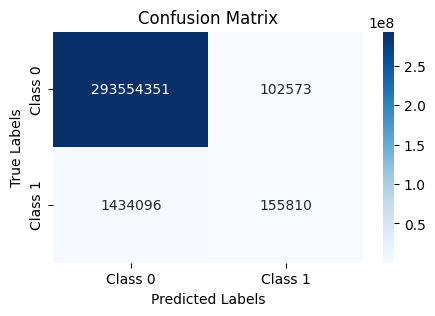

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

print(TP, FP, TN, FN)
confusion_matrix = [
    [TN, FP],
    [FN, TP]
]

plt.figure(figsize=(5, 3))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [60]:
(100*155810)/(155810+1434096), (100*1434096)/(155810+1434096)

(9.799950437321451, 90.20004956267854)

In [56]:
# Calculate Precision and Recall
precision = TP / (TP + FP) if (TP + FP) > 0 else 0  # Precision = TP / (TP + FP)
recall = TP / (TP + FN) if (TP + FN) > 0 else 0      # Recall = TP / (TP + FN)

precision, recall

(0.6030195484997078, 0.09799950437321452)

In [ ]:
'''
To calculate Mean Average Precision (mAP), you need to use the precision at 
different recall levels. The formula for Average Precision (AP) for each class 
is the area under the Precision-Recall Curve, which involves precision and 
recall values calculated at multiple thresholds.
'''
'''
In a binary classification task, the mAP is equivalent to the AP since you 
only have one class. In a multi-class or multi-label task, you would compute 
the AP for each class and then average them to get the mAP.
'''
# Calculate Average Precision (AP) for binary classification
# AP is calculated as the area under the precision-recall curve
# Here we are assuming precision and recall are given as single values, 
# but you can extend this by calculating precision and recall at multiple thresholds

# Create precision-recall curve data (in a real case, you would get this from a classifier)
# Assuming we are working with a single class, and you have precision and recall values at different thresholds.
precisions = [0.9, 0.8, 0.7]  # Example precision values at different thresholds
recalls = [0.1, 0.5, 1.0]    # Example recall values at different thresholds

# Calculate Average Precision (AP) using precision-recall pairs
ap = 0
for i in range(1, len(precisions)):
    recall_diff = recalls[i] - recalls[i - 1]
    ap += precisions[i] * recall_diff

# Calculate mAP (For multi-class, you'd compute AP for each class and then average them)
mAP = ap  # In this case, mAP is equal to AP as it's binary classification
print(f"Mean Average Precision (mAP): {mAP}")

## Test Inference

In [26]:
test_df = spark.read.format('parquet').load('test_features.parquet')
test_df = protein_ohe.transform(test_df)
test_df2 = vectorAssembler.transform(test_df)
test_predictions = xgb_model.transform(test_df2)
test_predictions_with_prob = test_predictions.select("features", "y", "prediction", "probability")
test_predictions_with_prob.show()

2024-12-25 23:44:24,155 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
[Stage 40:==========================================================(4 + 0) / 4]

+--------------------+---+----------+--------------------+
|            features|  y|prediction|         probability|
+--------------------+---+----------+--------------------+
|(99,[1,3,4,5,6,7,...|  2|       0.0|[0.99720060825347...|
|(99,[2,3,4,5,6,7,...|  2|       0.0|[0.71769237518310...|
|(99,[3,4,5,6,7,10...|  2|       0.0|[0.99608540534973...|
|(99,[1,3,4,5,6,7,...|  2|       0.0|[0.99871140718460...|
|(99,[2,3,4,5,6,7,...|  2|       0.0|[0.99597078561782...|
|(99,[3,4,5,6,7,10...|  2|       0.0|[0.99902218580245...|
|(99,[1,3,4,5,6,7,...|  2|       0.0|[0.99875897169113...|
|(99,[2,3,4,5,6,7,...|  2|       0.0|[0.99942106008529...|
|(99,[3,4,5,6,7,10...|  2|       0.0|[0.99850010871887...|
|(99,[1,3,4,5,6,7,...|  2|       0.0|[0.99829071760177...|
|(99,[2,3,4,5,6,7,...|  2|       0.0|[0.99590224027633...|
|(99,[3,4,5,6,7,10...|  2|       0.0|[0.99841290712356...|
|(99,[1,3,4,5,6,7,...|  2|       0.0|[0.99915039539337...|
|(99,[2,3,4,5,6,7,...|  2|       0.0|[0.99930113554000..

In [42]:
test_prob = np.array(test_predictions_with_prob.select('probability').collect()).reshape(-1,2)[:,1]

2024-12-25 23:54:32,247 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
                                                                                

In [43]:
test_prob

array([0.00279941, 0.28230765, 0.00391461, ..., 0.00182203, 0.00232565,
       0.00161004])

In [50]:
np.unique(np.array(test_predictions_with_prob.select('prediction').collect()), return_counts=True)

2024-12-25 23:59:20,489 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
                                                                                

(array([0., 1.]), array([1672597,    2299]))

In [44]:
import pandas as pd
import numpy as np

In [45]:
sub_df = pd.read_csv('sample_submission.csv.zip')
sub_df

,id,binds
0,295246830,0.5
1,295246831,0.5
2,295246832,0.5
3,295246833,0.5
4,295246834,0.5
...,...,...
1674891,296921721,0.5
1674892,296921722,0.5
1674893,296921723,0.5
1674894,296921724,0.5


In [46]:
sub_df.binds = test_prob
sub_df

,id,binds
0,295246830,0.002799
1,295246831,0.282308
2,295246832,0.003915
3,295246833,0.001289
4,295246834,0.004029
...,...,...
1674891,296921721,0.000432
1674892,296921722,0.001171
1674893,296921723,0.001822
1674894,296921724,0.002326


In [52]:
import subprocess, os

file_name = f"submission_csv/_2_submission_PySpark_XGB.csv"
message = f"PySpark XGB"
os.makedirs("submission_csv", exist_ok=True)

sub_df.to_csv(file_name, index=False)
display(pd.read_csv(file_name))

command = [
    "kaggle", "competitions", "submit",
    "-c", "leash-BELKA",
    "-f", file_name,
    "-m", message
]

subprocess.run(command)

,id,binds
0,295246830,0.002799
1,295246831,0.282308
2,295246832,0.003915
3,295246833,0.001289
4,295246834,0.004029
...,...,...
1674891,296921721,0.000432
1674892,296921722,0.001171
1674893,296921723,0.001822
1674894,296921724,0.002326


100%|██████████| 50.7M/50.7M [00:16<00:00, 3.31MB/s]  


Successfully submitted to NeurIPS 2024 - Predict New Medicines with BELKA

CompletedProcess(args=['kaggle', 'competitions', 'submit', '-c', 'leash-BELKA', '-f', 'submission_csv/_2_submission_PySpark_XGB.csv', '-m', 'PySpark XGB'], returncode=0)

24/12/26 00:12:39 WARN JavaUtils: Attempt to delete using native Unix OS command failed for path = /home/23m1521/ashish/kaggle/temp/blockmgr-3fc138e1-0b9b-4f5a-9741-b961499799a1. Falling back to Java IO way
java.io.IOException: Failed to delete: /home/23m1521/ashish/kaggle/temp/blockmgr-3fc138e1-0b9b-4f5a-9741-b961499799a1
	at org.apache.spark.network.util.JavaUtils.deleteRecursivelyUsingUnixNative(JavaUtils.java:174)
	at org.apache.spark.network.util.JavaUtils.deleteRecursively(JavaUtils.java:109)
	at org.apache.spark.network.util.JavaUtils.deleteRecursively(JavaUtils.java:90)
	at org.apache.spark.util.SparkFileUtils.deleteRecursively(SparkFileUtils.scala:121)
	at org.apache.spark.util.SparkFileUtils.deleteRecursively$(SparkFileUtils.scala:120)
	at org.apache.spark.util.Utils$.deleteRecursively(Utils.scala:1126)
	at org.apache.spark.storage.DiskBlockManager.$anonfun$doStop$1(DiskBlockManager.scala:368)
	at org.apache.spark.storage.DiskBlockManager.$anonfun$doStop$1$adapted(DiskBlockMa

///////////////////////////////////////////////////////////////////////////////////////////////////////////////////

In [11]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

xgb_classifier = SparkXGBClassifier(label_col="y", features_col="features")
evaluator = BinaryClassificationEvaluator(labelCol="y", metricName="areaUnderPR")

param_grid = ParamGridBuilder() \
    .addGrid(xgb_classifier.max_depth, [3, 5, 7, 10]) \
    .addGrid(xgb_classifier.learning_rate , [0.01, 0.1, 0.2, 0.3]) \
    .addGrid(xgb_classifier.subsample, [0.6, 0.8, 1.0]) \
    .addGrid(xgb_classifier.colsample_bytree, [0.6, 0.8, 1.0]) \
    .addGrid(xgb_classifier.gamma, [0, 0.1, 0.2, 0.5]) \
    .addGrid(xgb_classifier.min_child_weight, [1, 3, 5]) \
    .addGrid(xgb_classifier.reg_lambda, [0, 1, 5]) \
    .addGrid(xgb_classifier.reg_alpha, [0, 1, 5]) \
    .addGrid(xgb_classifier.n_estimators, [3000]) \
    .build()

crossval = CrossValidator(estimator=xgb_classifier,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=5)

cv_model = crossval.fit(full_df2)

best_model = cv_model.bestModel
model_path = "checkpoints/_2_XGB_CV"
best_model.save(best_model_path)

predictions = best_model.transform(full_df2)

aucPR = evaluator.evaluate(predictions)
print(f"Test AUC-PR: {aucPR}")

best_params = cv_model.bestModel.extractParamMap()
print("Best Hyperparameters:")
for param, value in best_params.items():
    print(f"{param.name}: {value}")

24/12/26 05:30:16 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/12/26 06:33:17 WARN MemoryStore: Not enough space to cache rdd_44_171 in memory! (computed 44.7 MiB so far)
24/12/26 06:33:17 WARN BlockManager: Persisting block rdd_44_171 to disk instead.
24/12/26 06:33:17 WARN MemoryStore: Not enough space to cache rdd_44_139 in memory! (computed 86.8 MiB so far)
24/12/26 06:33:17 WARN BlockManager: Persisting block rdd_44_139 to disk instead.
24/12/26 06:33:18 WARN MemoryStore: Not enough space to cache rdd_44_141 in memory! (computed 86.8 MiB so far)
24/12/26 06:33:18 WARN BlockManager: Persisting block rdd_44_141 to disk instead.
24/12/26 06:33:18 WARN MemoryStore: Not enough space to cache rdd_44_173 in memory! (computed 44.7 MiB so far)
24/12/26 06:33:18 WARN BlockManager: Persisting block rdd_44_173 to disk instead.
24/12/26 06:33:18 WARN MemoryStore: Not

[3980.477s][warning][gc,alloc] Executor task launch worker for task 185.0 in stage 13.0 (TID 920): Retried waiting for GCLocker too often allocating 76014 words
[3980.485s][warning][gc,alloc] Executor task launch worker for task 137.0 in stage 13.0 (TID 872): Retried waiting for GCLocker too often allocating 104891 words
[3980.485s][warning][gc,alloc] Spark Context Cleaner: Retried waiting for GCLocker too often allocating 331 words
[3980.494s][warning][gc,alloc] Executor task launch worker for task 165.0 in stage 13.0 (TID 900): Retried waiting for GCLocker too often allocating 57427 words
[3980.515s][warning][gc,alloc] Executor task launch worker for task 134.0 in stage 13.0 (TID 869): Retried waiting for GCLocker too often allocating 107590 words


24/12/26 06:33:27 WARN MemoryStore: Not enough space to cache rdd_44_190 in memory! (computed 44.7 MiB so far)
24/12/26 06:33:27 WARN BlockManager: Persisting block rdd_44_190 to disk instead.
24/12/26 06:33:27 WARN MemoryStore: Not enough space to cache rdd_44_158 in memory! (computed 86.8 MiB so far)
24/12/26 06:33:27 WARN BlockManager: Persisting block rdd_44_158 to disk instead.


[3980.892s][warning][gc,alloc] Executor task launch worker for task 130.0 in stage 13.0 (TID 865): Retried waiting for GCLocker too often allocating 115185 words


24/12/26 06:33:29 WARN MemoryStore: Not enough space to cache rdd_44_162 in memory! (computed 86.8 MiB so far)
24/12/26 06:33:29 WARN BlockManager: Persisting block rdd_44_162 to disk instead.
24/12/26 06:33:29 WARN MemoryStore: Not enough space to cache rdd_44_163 in memory! (computed 86.8 MiB so far)
24/12/26 06:33:29 WARN BlockManager: Persisting block rdd_44_163 to disk instead.
24/12/26 06:33:30 WARN MemoryStore: Not enough space to cache rdd_44_168 in memory! (computed 86.8 MiB so far)
24/12/26 06:33:30 WARN BlockManager: Persisting block rdd_44_168 to disk instead.
24/12/26 06:33:30 WARN MemoryStore: Not enough space to cache rdd_44_166 in memory! (computed 86.8 MiB so far)
24/12/26 06:33:30 WARN BlockManager: Persisting block rdd_44_166 to disk instead.
24/12/26 06:33:30 WARN MemoryStore: Not enough space to cache rdd_44_167 in memory! (computed 86.8 MiB so far)
24/12/26 06:33:30 WARN BlockManager: Persisting block rdd_44_167 to disk instead.
24/12/26 06:33:38 WARN MemoryStore:

[3994.854s][warning][gc,alloc] Executor task launch worker for task 172.0 in stage 13.0 (TID 907): Retried waiting for GCLocker too often allocating 96676 words
[3994.855s][warning][gc,alloc] Executor task launch worker for task 163.0 in stage 13.0 (TID 898): Retried waiting for GCLocker too often allocating 87102 words
[3994.855s][warning][gc,alloc] Executor task launch worker for task 148.0 in stage 13.0 (TID 883): Retried waiting for GCLocker too often allocating 105646 words
[3994.855s][warning][gc,alloc] Executor task launch worker for task 154.0 in stage 13.0 (TID 889): Retried waiting for GCLocker too often allocating 92596 words
[3994.865s][warning][gc,alloc] Executor task launch worker for task 159.0 in stage 13.0 (TID 894): Retried waiting for GCLocker too often allocating 98146 words
[3994.865s][warning][gc,alloc] Executor task launch worker for task 131.0 in stage 13.0 (TID 866): Retried waiting for GCLocker too often allocating 95239 words
[3994.865s][warning][gc,alloc] Ex

24/12/26 06:33:41 WARN BlockManager: Block rdd_44_152 could not be removed as it was not found on disk or in memory
24/12/26 06:33:41 ERROR Executor: Exception in task 152.0 in stage 13.0 (TID 887)
java.lang.OutOfMemoryError: Java heap space
	at java.base/java.nio.HeapByteBuffer.<init>(HeapByteBuffer.java:64)
	at java.base/java.nio.ByteBuffer.allocate(ByteBuffer.java:363)
	at org.apache.spark.sql.execution.columnar.BasicColumnBuilder.initialize(ColumnBuilder.scala:68)
	at org.apache.spark.sql.execution.columnar.NativeColumnBuilder.org$apache$spark$sql$execution$columnar$NullableColumnBuilder$$super$initialize(ColumnBuilder.scala:99)
	at org.apache.spark.sql.execution.columnar.NullableColumnBuilder.initialize(NullableColumnBuilder.scala:51)
	at org.apache.spark.sql.execution.columnar.NullableColumnBuilder.initialize$(NullableColumnBuilder.scala:42)
	at org.apache.spark.sql.execution.columnar.NativeColumnBuilder.org$apache$spark$sql$execution$columnar$compression$CompressibleColumnBuilde

Py4JJavaError: An error occurred while calling o3975.javaToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 152 in stage 13.0 failed 1 times, most recent failure: Lost task 152.0 in stage 13.0 (TID 887) (kanjur.ieor.iitb.ac.in executor driver): java.lang.OutOfMemoryError: Java heap space
	at java.base/java.nio.HeapByteBuffer.<init>(HeapByteBuffer.java:64)
	at java.base/java.nio.ByteBuffer.allocate(ByteBuffer.java:363)
	at org.apache.spark.sql.execution.columnar.BasicColumnBuilder.initialize(ColumnBuilder.scala:68)
	at org.apache.spark.sql.execution.columnar.NativeColumnBuilder.org$apache$spark$sql$execution$columnar$NullableColumnBuilder$$super$initialize(ColumnBuilder.scala:99)
	at org.apache.spark.sql.execution.columnar.NullableColumnBuilder.initialize(NullableColumnBuilder.scala:51)
	at org.apache.spark.sql.execution.columnar.NullableColumnBuilder.initialize$(NullableColumnBuilder.scala:42)
	at org.apache.spark.sql.execution.columnar.NativeColumnBuilder.org$apache$spark$sql$execution$columnar$compression$CompressibleColumnBuilder$$super$initialize(ColumnBuilder.scala:99)
	at org.apache.spark.sql.execution.columnar.compression.CompressibleColumnBuilder.initialize(CompressibleColumnBuilder.scala:62)
	at org.apache.spark.sql.execution.columnar.compression.CompressibleColumnBuilder.initialize$(CompressibleColumnBuilder.scala:51)
	at org.apache.spark.sql.execution.columnar.NativeColumnBuilder.initialize(ColumnBuilder.scala:99)
	at org.apache.spark.sql.execution.columnar.ColumnBuilder$.apply(ColumnBuilder.scala:203)
	at org.apache.spark.sql.execution.columnar.DefaultCachedBatchSerializer$$anon$1.$anonfun$next$1(InMemoryRelation.scala:83)
	at org.apache.spark.sql.execution.columnar.DefaultCachedBatchSerializer$$anon$1$$Lambda$6859/0x00007fe5413e6f80.apply(Unknown Source)
	at scala.collection.TraversableLike.$anonfun$map$1(TraversableLike.scala:286)
	at scala.collection.TraversableLike$$Lambda$159/0x00007fe540217240.apply(Unknown Source)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at scala.collection.TraversableLike.map(TraversableLike.scala:286)
	at scala.collection.TraversableLike.map$(TraversableLike.scala:279)
	at scala.collection.AbstractTraversable.map(Traversable.scala:108)
	at org.apache.spark.sql.execution.columnar.DefaultCachedBatchSerializer$$anon$1.next(InMemoryRelation.scala:82)
	at org.apache.spark.sql.execution.columnar.DefaultCachedBatchSerializer$$anon$1.next(InMemoryRelation.scala:80)
	at org.apache.spark.sql.execution.columnar.CachedRDDBuilder$$anon$2.next(InMemoryRelation.scala:290)
	at org.apache.spark.sql.execution.columnar.CachedRDDBuilder$$anon$2.next(InMemoryRelation.scala:287)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:224)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:302)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$1(BlockManager.scala:1597)
	at org.apache.spark.storage.BlockManager$$Lambda$1506/0x00007fe5408d2050.apply(Unknown Source)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$doPut(BlockManager.scala:1524)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1588)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1389)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: java.lang.OutOfMemoryError: Java heap space
	at java.base/java.nio.HeapByteBuffer.<init>(HeapByteBuffer.java:64)
	at java.base/java.nio.ByteBuffer.allocate(ByteBuffer.java:363)
	at org.apache.spark.sql.execution.columnar.BasicColumnBuilder.initialize(ColumnBuilder.scala:68)
	at org.apache.spark.sql.execution.columnar.NativeColumnBuilder.org$apache$spark$sql$execution$columnar$NullableColumnBuilder$$super$initialize(ColumnBuilder.scala:99)
	at org.apache.spark.sql.execution.columnar.NullableColumnBuilder.initialize(NullableColumnBuilder.scala:51)
	at org.apache.spark.sql.execution.columnar.NullableColumnBuilder.initialize$(NullableColumnBuilder.scala:42)
	at org.apache.spark.sql.execution.columnar.NativeColumnBuilder.org$apache$spark$sql$execution$columnar$compression$CompressibleColumnBuilder$$super$initialize(ColumnBuilder.scala:99)
	at org.apache.spark.sql.execution.columnar.compression.CompressibleColumnBuilder.initialize(CompressibleColumnBuilder.scala:62)
	at org.apache.spark.sql.execution.columnar.compression.CompressibleColumnBuilder.initialize$(CompressibleColumnBuilder.scala:51)
	at org.apache.spark.sql.execution.columnar.NativeColumnBuilder.initialize(ColumnBuilder.scala:99)
	at org.apache.spark.sql.execution.columnar.ColumnBuilder$.apply(ColumnBuilder.scala:203)
	at org.apache.spark.sql.execution.columnar.DefaultCachedBatchSerializer$$anon$1.$anonfun$next$1(InMemoryRelation.scala:83)
	at org.apache.spark.sql.execution.columnar.DefaultCachedBatchSerializer$$anon$1$$Lambda$6859/0x00007fe5413e6f80.apply(Unknown Source)
	at scala.collection.TraversableLike.$anonfun$map$1(TraversableLike.scala:286)
	at scala.collection.TraversableLike$$Lambda$159/0x00007fe540217240.apply(Unknown Source)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at scala.collection.TraversableLike.map(TraversableLike.scala:286)
	at scala.collection.TraversableLike.map$(TraversableLike.scala:279)
	at scala.collection.AbstractTraversable.map(Traversable.scala:108)
	at org.apache.spark.sql.execution.columnar.DefaultCachedBatchSerializer$$anon$1.next(InMemoryRelation.scala:82)
	at org.apache.spark.sql.execution.columnar.DefaultCachedBatchSerializer$$anon$1.next(InMemoryRelation.scala:80)
	at org.apache.spark.sql.execution.columnar.CachedRDDBuilder$$anon$2.next(InMemoryRelation.scala:290)
	at org.apache.spark.sql.execution.columnar.CachedRDDBuilder$$anon$2.next(InMemoryRelation.scala:287)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:224)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:302)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$1(BlockManager.scala:1597)
	at org.apache.spark.storage.BlockManager$$Lambda$1506/0x00007fe5408d2050.apply(Unknown Source)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$doPut(BlockManager.scala:1524)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1588)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1389)


24/12/26 06:34:11 WARN ShutdownHookManager: ShutdownHook '' timeout, java.util.concurrent.TimeoutException
java.util.concurrent.TimeoutException
	at java.base/java.util.concurrent.FutureTask.get(FutureTask.java:204)
	at org.apache.hadoop.util.ShutdownHookManager.executeShutdown(ShutdownHookManager.java:124)
	at org.apache.hadoop.util.ShutdownHookManager$1.run(ShutdownHookManager.java:95)
24/12/26 06:34:11 WARN JavaUtils: Attempt to delete using native Unix OS command failed for path = /home/23m1521/ashish/kaggle/temp/blockmgr-d454b1a4-d4b7-4a85-b2aa-db18a5627146. Falling back to Java IO way
java.io.IOException: Failed to delete: /home/23m1521/ashish/kaggle/temp/blockmgr-d454b1a4-d4b7-4a85-b2aa-db18a5627146
	at org.apache.spark.network.util.JavaUtils.deleteRecursivelyUsingUnixNative(JavaUtils.java:166)
	at org.apache.spark.network.util.JavaUtils.deleteRecursively(JavaUtils.java:109)
	at org.apache.spark.network.util.JavaUtils.deleteRecursively(JavaUtils.java:90)
	at org.apache.spark.uti

//////////////////////////////////////////////////////////////////////////////////////////////